## Introduction: 

The notebook provides exploratory analysis of Taxi Data (TDrive) in Bejing (700MB of csv data)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point, LineString
from sklearn.preprocessing import StandardScaler
from dateutil import rrule
import datetime
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

%matplotlib inline

# 0. Data pre-processing

Full data spans from "2008-02-02" till "2008-02-08". City of Bejing.

In [6]:
df_main=pd.read_csv('/Users/stanislav/Desktop/NYU/NYURESEARCH/HITPACER/Taxi_Trajectory-Clustering/release/taxi_log_2008_by_id/Tdrive.csv', names=['trip_id','timestamp','long','lat'])

In [7]:
# import data
#df_main = pd.read_csv('20190425_trajectories.csv') - 

# view the data - 17.6Mln records
print(df_main.shape)
df_main.head()

(17662984, 4)


,trip_id,timestamp,long,lat
0,1,2008-02-02 15:36:08,116.51172,39.92123
1,1,2008-02-02 15:46:08,116.51135,39.93883
2,1,2008-02-02 15:46:08,116.51135,39.93883
3,1,2008-02-02 15:56:08,116.51627,39.91034
4,1,2008-02-02 16:06:08,116.47186,39.91248


In [8]:
(min(df_main.long),max(df_main.long))

(0.0, 255.3)

In [9]:
(min(df_main.lat),max(df_main.lat))

(0.0, 96.06766999999999)

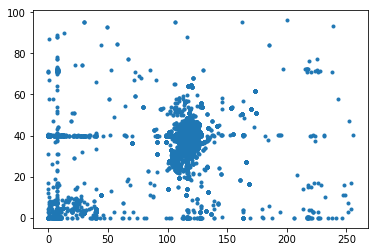

In [10]:
#rough data spans all around the world
plt.scatter(df_main.long,df_main.lat, marker = '.')

In [11]:
#but more than 99% of reconds are contained within a following 2 degree square, resembling the city shape
ind=(df_main['long'] > 115.5) & (df_main['long'] < 117.5) \
& (df_main['lat'] > 39) & (df_main['lat'] < 41)
df_filter=df_main.loc[ind]
1.0*len(df_filter)/len(df_main)

0.9908904407092256

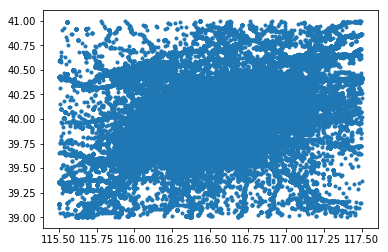

In [12]:
plt.scatter(df_filter.long,df_filter.lat, marker = '.')

In [13]:
#Remaining 17.5M location records
len(df_filter)

17502082

In [14]:
#number of active vehicles - 10290
VN=len(df_filter.trip_id.unique()); VN

10290

In [15]:
#average of 1700 points per vehicle
1.0*len(df_filter)/VN

1700.8826044703596

In [16]:
df_filter.timestamp=pd.to_datetime(df_filter.timestamp)

/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
#timeframe - 1 week in Feb,2018
df_filter.timestamp.min(),df_filter.timestamp.max()

(Timestamp('2008-02-02 13:30:44'), Timestamp('2008-02-08 17:39:19'))

In [19]:
df_filter.to_pickle('TDriveFilt99.pkl')

# 1. Exploratory analysis

In [2]:
df = pd.read_pickle('TDriveFilt99.pkl')

In [3]:
VStat=df.groupby(['trip_id']).agg({'timestamp':[min,max,'count']})

In [4]:
VStat['duration']=VStat.timestamp['max']-VStat.timestamp['min']

In [5]:
VStat.head()

timestamp                                  duration
                        min                 max count                
trip_id                                                              
1       2008-02-02 15:36:08 2008-02-08 15:51:31   588 6 days 00:15:23
2       2008-02-02 13:33:52 2008-02-08 17:38:45  1674 6 days 04:04:53
3       2008-02-02 13:39:08 2008-02-08 17:35:23  1371 6 days 03:56:15
4       2008-02-02 15:15:04 2008-02-08 17:39:03   672 6 days 02:23:59
5       2008-02-02 13:43:04 2008-02-08 17:38:58   798 6 days 03:55:54

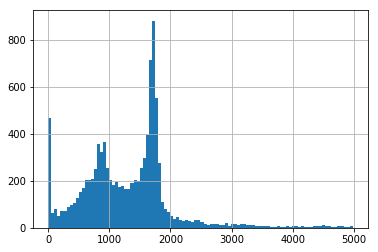

In [6]:
VStat.loc[VStat.timestamp['count']<5000].timestamp['count'].hist(bins=100)

In [ ]:
#!!!Below would be great to have some unified quantile calculation; show averages and quantiles on the distribution plot

In [7]:
#89% of taxies have below 2000 records
1.0*sum(VStat.timestamp['count']<2000)/len(VStat)

0.8937803692905734

In [8]:
#88% of taxies have above 500 records
1.0*sum(VStat.timestamp['count']>500)/len(VStat)

0.8814382896015549

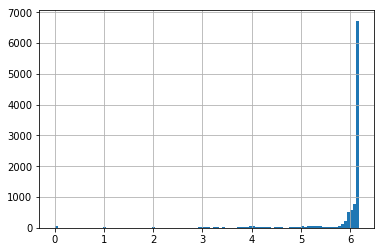

In [9]:
(VStat.duration / datetime.timedelta(days=1)).hist(bins=100)

In [10]:
#Activity interval for 92% of taxies is at least 5 days !!! same here - 90/95% quantiles and average on the plot would be nice. Perhaps play with x/y range and log-scale
1.0*sum(VStat.duration>datetime.timedelta(days=5))/len(VStat)

0.9231292517006803

In [11]:
#Typical activity frequency is 70-400 records per day. But its not homogenous over time

In [12]:
#distribution of time intervals between consequitive readings for a single vehicle; takes 2 min to run
I=[]
for T in df.trip_id.unique():
    df_T=df.loc[df.trip_id==T]
    t=np.array(df_T.timestamp.sort_values())
    I+=list((t[1:]-t[:-1])/np.timedelta64(1, 's'))

In [76]:
I_=pd.Series(I)

In [ ]:
#This is the most important part so far - need to get an idea what are the typical range for the time intervals between consequitive measurements and what can signal a break between trajectory segments

In [96]:
#96% of intervals are 10 minutes or less
1.0*sum(I_<=600)/len(I_)

0.9681419147906629

In [83]:
#40% of intervals under a minute
1.0*sum(I_<=60)/len(I_)

0.3950754159436609

In [85]:
#25% of intervals under 5 seconds
1.0*sum(I_<=5)/len(I_)

0.2446343976649162

In [89]:
#0.5% of intervals are over 1 hour - significant trajectory breaks
1.0*sum(I_>=3600)/len(I_)

0.004655555016890208

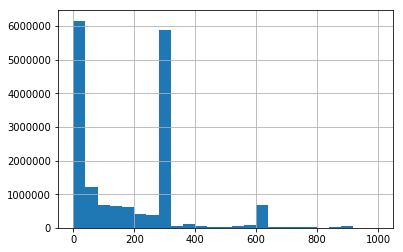

In [94]:
#from the below it seems like there are 3 typical intervals - one really small (seconds), one - 5 minutes and another - 10 minutes.
I_[I_<1000].hist(bins=25)

In [98]:
#Typical intervals are around 6 minutes or less
1.0*sum(I_<=360)/len(I_)

0.9200657085334653

In [120]:
#some examples of trajectories - what we're looking for are the ones which show some repeated patterns or interesting ourliers; further we'll try to find those algorithmically, for now just manually picked examples
Tr=[10093,1005,1025,1,10061,10063,10067,10082]

In [98]:
def PlotTrajectory(i):
    plt.figure()
    plt.title(str(i))
    plt.plot(df.loc[df['trip_id']==i, 'long'], df.loc[df['trip_id']==i,'lat'], marker = 'o', c= np.random.rand(3,))
    plt.xticks([])
    plt.yticks([])

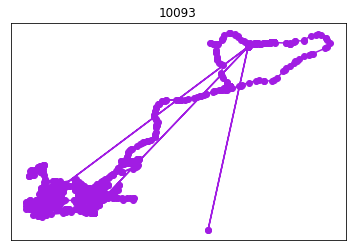

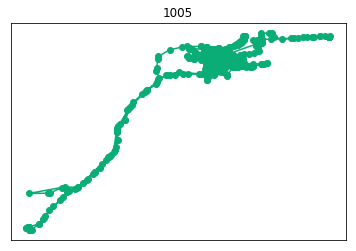

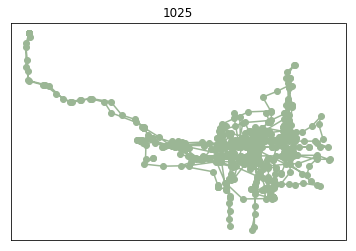

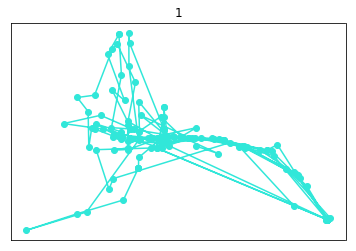

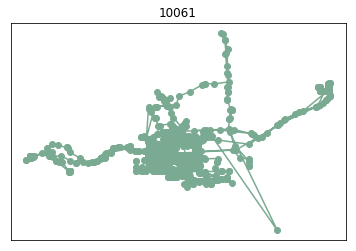

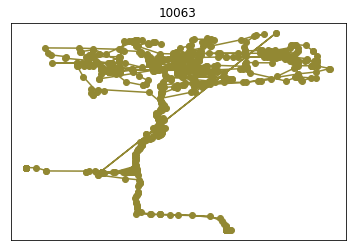

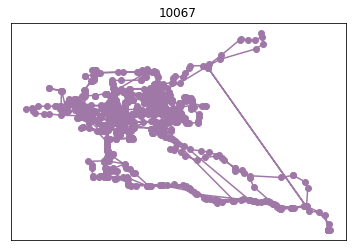

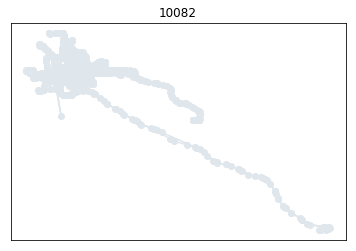

In [122]:
for i in Tr:#df_main['trip_id'].unique()[100:130]:
    PlotTrajectory(i)

In [3]:
df['Y']=df.lat
df['X']=df.long/np.cos(40*np.pi/180)

In [6]:
df.head()

,trip_id,timestamp,long,lat,Y,X
0,1,2008-02-02 15:36:08,116.51172,39.92123,39.92123,152.095249
1,1,2008-02-02 15:46:08,116.51135,39.93883,39.93883,152.094766
2,1,2008-02-02 15:46:08,116.51135,39.93883,39.93883,152.094766
3,1,2008-02-02 15:56:08,116.51627,39.91034,39.91034,152.101188
4,1,2008-02-02 16:06:08,116.47186,39.91248,39.91248,152.043215
